In [2]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
import itertools

Populating the interactive namespace from numpy and matplotlib


In [3]:
from xgboost import XGBClassifier

/home/s2401479/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data and create X_train and X_train_scaled

In [4]:
y = pd.read_csv('labelsFlowCapAnalysis2017.csv')
y = y - 1
print(y.shape)
print(y.S_labels.value_counts())
y = y.iloc[:, 0]

(179, 1)
0    156
1     23
Name: S_labels, dtype: int64


Here we delete #71 because in a separate notebook it always lied inside "cloud" of other points and all algorithms made a mistake on it. Thus, for "better" learning we decided to delete it. 

In [5]:
y = list(y.values[:71]) + list(y.values[72:])

In [6]:
y = np.asarray(y)

In [7]:
df = pd.read_csv('featuresFlowCapAnalysis2017.csv')

In [8]:
df.shape

df = df.drop(df.index[71])
df.shape

(358, 186)

In [9]:
X_train = df.iloc[:178, :]
X_test = df.iloc[178:, :]

In [10]:
X_test.shape

(180, 186)

In [11]:
scaler =  StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))

In [12]:
X_train_scaled = df_scaled.iloc[:178, :]
X_test_scaled = df_scaled.iloc[178:, :]

## Algorithm for stacking

In [13]:
def compute_meta_feature(clf, X_train, X_test, y_train):
    clf.fit(X_train, y_train)
    
    if 'predict_proba' in dir(clf):
        return cross_val_predict(clf, X_train, y_train, \
                cv=KFold(n_splits=5, random_state=42, shuffle=True), n_jobs=-1, method='predict_proba')[:, 0], \
                clf.predict_proba(X_test)[:, 0]
    else:
        print("Use method with predict proba, please. Otherwise, stacking will not work correctly because of mixing different formats.")

In [14]:
X_train_cv = pd.DataFrame()
X_test_ans = pd.DataFrame()

## How to make new features with algorithm

## 1) Use just simple algorithm, like this

## PLEASE UNCOMMENT and CHANGE y HERE for a outlier like this

In [15]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, max_features=10)
X_train_cv['AlexRF'], X_test_ans['AlexRF'] = compute_meta_feature(rf, X_train_scaled, X_test_scaled, y)

In [18]:
lr = LogisticRegression(penalty='l2', C=0.8)
X_train_cv['AlexLR'], X_test_ans['AlexLR'] = compute_meta_feature(lr, X_train_scaled, X_test_scaled, y)

## 2) use pipeline if you need several  steps

In [21]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=20)),
    ('clf', XGBClassifier(n_estimators=1))
])
X_train_cv['AlexXGB'], X_test_ans['AlexXGB'] = compute_meta_feature(pipe, X_train_scaled, X_test_scaled, y)

KeyboardInterrupt: 

In [22]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=10)),
    ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance'))
])
X_train_cv['AlexKNN'], X_test_ans['AlexKNN'] = compute_meta_feature(pipe, X_train_scaled, X_test_scaled, y)

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=3)),
    ('clf', GaussianNB())
])


X_train_cv['AlexGNB'], X_test_ans['AlexGNB'] = compute_meta_feature(pipe, X_train_scaled, X_test_scaled, y)

## 3) If you do not have pipeline: Add cross_val_predict in X_train and true predictions for for X_test.

Let's add 1's

In [25]:
X_train_cv['ones'] = 1
X_test_ans['ones'] = 1

## Stacking itself (2 different algorithms) + blending

In [26]:
xgb = XGBClassifier(n_estimators=1000, nthread=-1)
lr = LogisticRegression(fit_intercept=True)

Choose best parameter

In [27]:
def plot_with_conf_interval(x, y, error, name_of_model, x_axis_name):

    plt.figure(figsize=(15, 6))
    plt.title(name_of_model, {'size': '18'})
    plt.ylabel("LOG LOSS score")

    if type(x[0]) == str:
        plt.xticks(range(len(y)), x)
        plt.xlim(-1, len(y))
        plt.errorbar(range(len(y)), y, yerr=1.96 * error, fmt='o')
    else:
        plt.xlabel(x_axis_name)
        plt.plot(x, y, color='b', label="score")
        plt.fill_between(x, y + 1.96 * error, y - 1.96 * error,
                         color='g', label='95% interval')

    plt.legend(loc='best')
    plt.show()

In [28]:
def blending(clf1, clf2, X, y, minim=0, maxim=1, step=0.05, number_of_splits=7):
    final_scores = []
    
    for alpha in np.arange(minim, maxim + step, step):
        result_for_alpha = []
        
        for i, j in KFold(n_splits=number_of_splits).split(X, y):
            X_train, X_test = X.loc[i], X.loc[j]
            y_train, y_test = y[i], y[j]
            
            clf1.fit(X_train, y_train)
            clf2.fit(X_train, y_train)
            
            prediction = alpha * clf1.predict_proba(X_test)[:, 1]  + (1 - alpha) * clf2.predict_proba(X_test)[:, 1]
            result_for_alpha.append(log_loss(y_test, prediction))
            
        final_scores.append(result_for_alpha)
    return final_scores

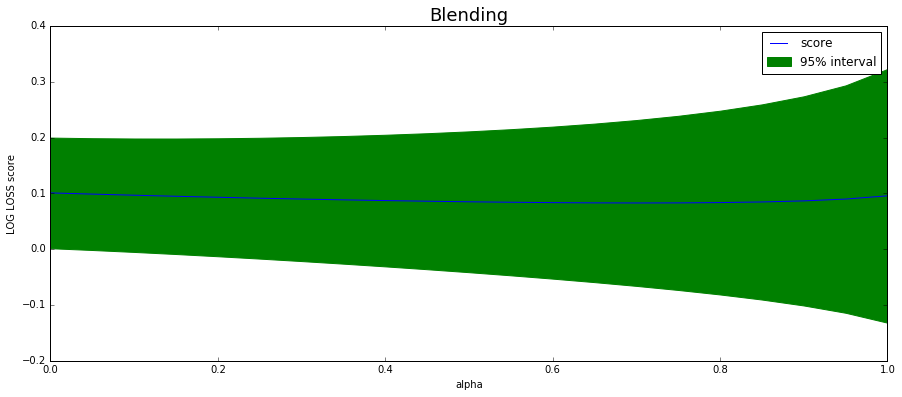

In [29]:
arr = blending(xgb, lr, X_train_cv, y)

mean = np.mean(arr, axis=1)
std = np.std(arr, axis=1)

plot_with_conf_interval(np.arange(0, 1.05, 0.05), mean, std, "Blending", "alpha")

In [30]:
optimal_alpha = argmin(mean)*0.05
optimal_alpha

0.70000000000000007

In [32]:
xgb.fit(X_train_cv, y)
lr.fit(X_train_cv, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**PLOT IMPORTANCES** (Just for fun)

([<matplotlib.axis.XTick at 0x7f8291984400>,
 <a list of 5 Text xticklabel objects>)

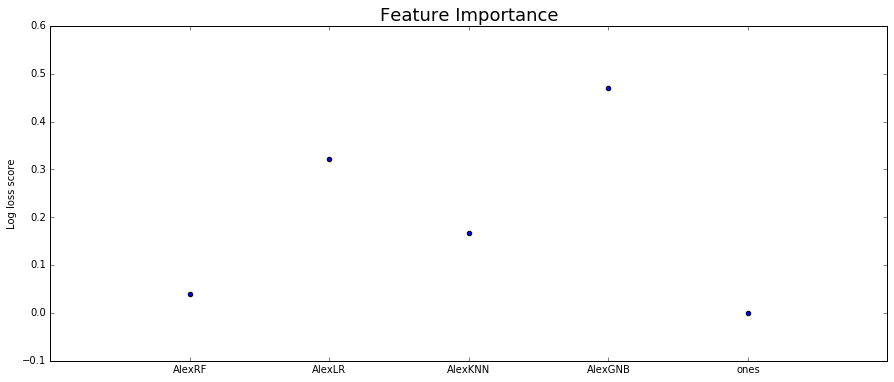

In [33]:
plt.figure(figsize=(15, 6))
plt.title("Feature Importance", {'size': '18'})
plt.ylabel("Log loss score")
plt.scatter(range(len(X_train_cv.columns)), xgb.feature_importances_)
plt.xticks(range(len(X_train_cv.columns)), X_train_cv.columns)

## Merge two algorithms result

In [34]:
y_xgb = xgb.predict_proba(X_test_ans)[:, 1]
y_lr = lr.predict_proba(X_test_ans)[:, 1]

In [35]:
y_test_merged = (optimal_alpha * y_xgb + (1 - optimal_alpha) * y_lr)

## Choose right border so it will give exactly 20!!!

In [36]:
(y_test_merged > 0.5).sum()

20

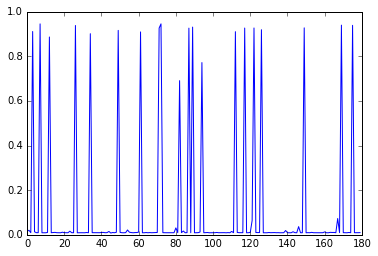

In [37]:
plot(y_test_merged)

## Looks like our algorithm already classifies it perfectly! (well, will see in two days)


In [38]:
y_test_final = (y_test_merged > 0.5).astype(int)

In [39]:
y_test_final

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

REPORT DRAFT - FILL AND CORRECT

LEVEL 1

We created several basic algorithms:

1) Random Forest with some parameters on scaled data

2) xgboost on scaled data

3) linear regr with l2 regularisation on scaled  data

4) ...

LEVEL 2

We fitted xgboost and logreg on metafeatures and find optimal parameter for blending (the only place where we ovefitted a little, previously we used cross val predict everywhere).

LEVEL 3

Final model is ALPHA * xgb + (1 -ALPHA ) * lr.

As we used probabilities everywhere, we chose such a border we will receive exactly 20 predictions.

## NOTE. (How all parameters were found, code for it)

In [40]:
def make_param_grids(steps, param_grids):

    final_params=[]

    # Itertools.product will do a permutation such that 
    # (pca OR svd) AND (svm OR rf) will become ->
    # (pca, svm) , (pca, rf) , (svd, svm) , (svd, rf)
    for estimator_names in itertools.product(*steps.values()):
        current_grid = {}

        # Step_name and estimator_name should correspond
        # i.e preprocessor must be from pca and select.
        for step_name, estimator_name in zip(steps.keys(), estimator_names):
            for param, value in param_grids.get(estimator_name).items():
                if param == 'object':
                    # Set actual estimator in pipeline
                    current_grid[step_name]=[value]
                else:
                    # Set parameters corresponding to above estimator
                    current_grid[step_name+'__'+param]=value
        #Append this dictionary to final params            
        final_params.append(current_grid)

    return final_params



In [121]:
# add all the estimators you want to "OR" in single key
# use OR between `pca` and `select`,
# use OR between `svm` and `rf`
# different keys will be evaluated as serial estimator in pipeline

pipe = Pipeline([
    ('reduce_dim', PCA()),
#     ('reduce_dim_2',  TSNE()),
    ('clf', RandomForestClassifier())
])


pipeline_steps = {'reduce_dim': ['pca', 'none'],
#                   'reduce_dim_2': ['tsne'],
                  'clf': ['xgb']}

# fill parameters to be searched in this dict
all_param_grids = {
    'none': {'object': None},

#     'minmax': {'object': StandardScaler(),
#                },

    'pca': {'object': PCA(),
            'n_components' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            },
    
    'gnb': {'object': GaussianNB(),},

     #'tsne' : {'object' : TSNE(),
     #         'n_components' : [2, 5, 10],
     #       },
    
    'knn': {'object': KNeighborsClassifier(n_jobs=-1),
            'weights': ['uniform', 'distance'],
            'n_neighbors': [1, 2, 3, 5],
            },

     'lr': {'object': LogisticRegression(),
            'penalty' :['l1', 'l2'],
            'C': [0.1, 0.2, 0.3],
            },

     'rf': {'object': RandomForestClassifier(),
            'n_estimators': [1000, 2000],
            },
    
    'dt': {'object': DecisionTreeClassifier(),
            'max_depth': [5, 10, 20],
            },
    
     'xgb': {'object': XGBClassifier(nthread=-1),
            'n_estimators': [50, 100],
             'max_depth' : [3],
             'min_child_weight' : [0.1],
     },

}


# Call the method on the above declared variables
param_grids_list = make_param_grids(pipeline_steps, all_param_grids)

In [ ]:
clf_first = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grids_list, scoring='neg_log_loss', verbose=1)
clf_first.fit(X_train, y)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


In [119]:
def PrintResults(clf):
    a = []
    for mean, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
        a.append([mean, params])
    a.sort(key=lambda x : -x[0])
    for x in a:
        print(x[0], ": ", x[1])
        print()

In [120]:
PrintResults(clf_first)

-0.0836916350782 :  {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__n_estimators': 2000, 'reduce_dim': None}

-0.0849262735328 :  {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__n_estimators': 1000, 'reduce_dim': None}

